In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.layers import RandomRotation, RandomBrightness, RandomZoom, RandomContrast, RandomFlip
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [2]:
TRAIN_DIR = "rice-disease-dataset"

train_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = (300, 300),
    batch_size = 32,
    label_mode = "categorical",
    validation_split = 0.2,
    seed = 42,
    subset = "both"
)

Found 240 files belonging to 3 classes.
Using 192 files for training.
Using 48 files for validation.


In [3]:
train_dataset_final = (
    train_dataset
    .cache()
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)
validation_dataset_final = (
    validation_dataset
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

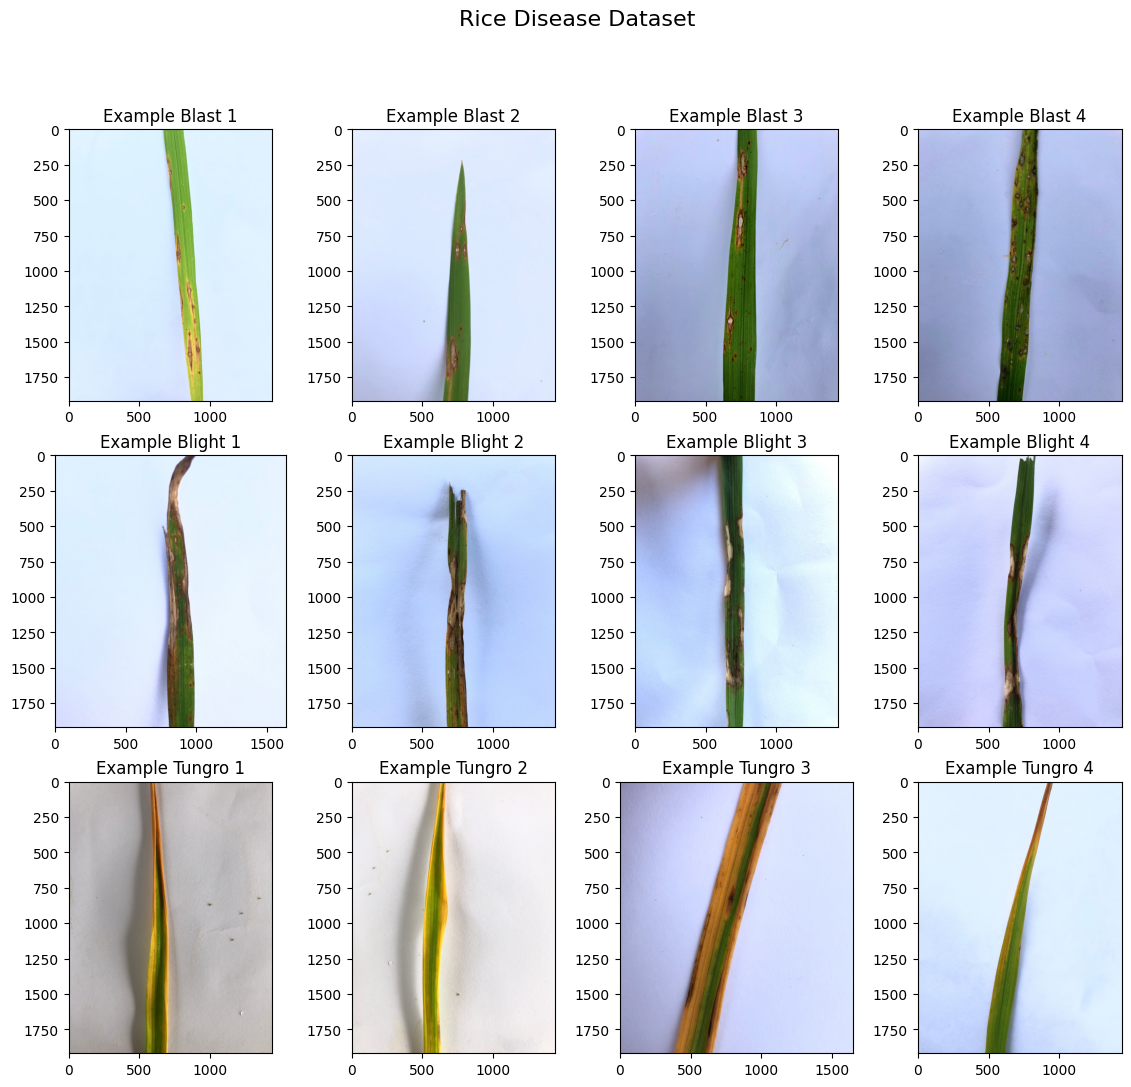

In [4]:
BLAST_DIR = f"{TRAIN_DIR}/blast"
BLIGHT_DIR = f"{TRAIN_DIR}/blight"
TUNGRO_DIR = f"{TRAIN_DIR}/tungro"

blast_filenames = os.listdir(BLAST_DIR)
blight_filenames = os.listdir(BLIGHT_DIR)
tungro_filenames = os.listdir(TUNGRO_DIR)

blast_images = [f"{BLAST_DIR}/{filename}" for filename in blast_filenames]
blight_images = [f"{BLIGHT_DIR}/{filename}" for filename in blight_filenames]
tungro_images = [f"{TUNGRO_DIR}/{filename}" for filename in tungro_filenames]

fig, ax = plt.subplots(3, 4, figsize=(14, 12))
plt.suptitle("Rice Disease Dataset", fontsize=16)

for i, blast_image in enumerate(blast_images[:4]):
    img = tf.keras.utils.load_img(blast_image)
    ax[0, i].imshow(img)
    ax[0, i].set_title(f"Example Blast {i+1}")

for i, blight_image in enumerate(blight_images[:4]):
    img = tf.keras.utils.load_img(blight_image)
    ax[1, i].imshow(img)
    ax[1, i].set_title(f"Example Blight {i+1}")

for i, tungro_image in enumerate(tungro_images[:4]):
    img = tf.keras.utils.load_img(tungro_image)
    ax[2, i].imshow(img)
    ax[2, i].set_title(f"Example Tungro {i+1}")

plt.show()

In [5]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs["accuracy"] >= 0.995:
            self.model.stop_training = True
            print("\nStop Training, accuracy already 95%")

In [6]:
augmentation_layers = Sequential(
    [
        tf.keras.Input(shape=(300, 300, 3)),
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.2),
        RandomBrightness(0.2),
        RandomZoom(0.1)
    ], name = "augmentation_layers"
)

In [7]:
model = Sequential(
    [
        tf.keras.Input(shape=(300, 300, 3)),
        augmentation_layers,
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax")
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layers             │ (None, 300, 300, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,419 (1.92 MB)

 Trainable params: 504,419 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    loss = CategoricalCrossentropy,
    optimizer = Adam(0.001),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    train_dataset_final,
    epochs = 50,
    validation_data = validation_dataset_final,
    callbacks = [EarlyStoppingCallback()]
)

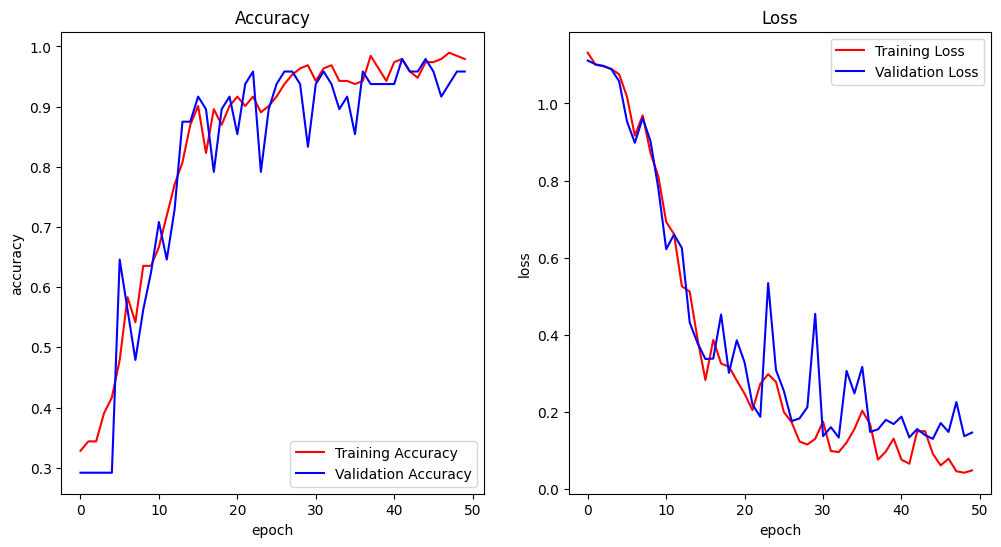

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(epochs, acc, "r", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "b", label="Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy")
ax[0].set_ylabel("accuracy")
ax[0].set_xlabel("epoch")

ax[1].plot(epochs, loss, "r", label="Training Loss")
ax[1].plot(epochs, val_loss, "b", label="Validation Loss")
ax[1].legend()
ax[1].set_title("Loss")
ax[1].set_ylabel("loss")
ax[1].set_xlabel("epoch")

plt.show()